In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_table('log.intEnergy')
df.head()

FileNotFoundError: File b'log.intEnergy' does not exist

In [ ]:
fileName = "log.intEnergy"
runNum = 1

search = "Step"
n = 1
f = open(fileName)
df = {}
EOF = False
while True:
    try:
        line = f.readline()
    except:
        break
    if search in line:
        if n == runNum:
            keys = line.split()
            for key in keys:
                df[key] = []
            while True:
                try:
                    line = f.readline()
                except:
                    EOF = True
                    break
                try:
                    values = list(float(x) for x in line.split())
                except:
                    break
                for i in range(len(keys)):
                    df[keys[i]].append(values[i])
        else:
            n += 1
    else:
        pass
    if len(df.keys()) > 0 or EOF:
        break
df = pd.DataFrame(df)
f.close()
print(df)

# Working Log file Reader 

test code for class


In [ ]:
filename = 'log.interfaceTracking'   #takes in filename
thermoLabels = 'Step Atoms Temp Press TotEng'.split()    #take in thermo output Labels/arguements
includeLabelsForNewRun = False

dataLines = []

f = open(filename,'r')
data = False
for line in f.readlines():
    #print(line.split())
    
    if data:
        if len(line.split())!= 0 and line.split()[0].isdigit():
            dataLines.append(line.split())
        else:
            data = False
    
    if line.split() == thermoLabels:
        data = True
        if includeLabelsForNewRun:
            dataLines.append(line.split())
    
f.close()

for i in dataLines:
    print(i)

#print(outputLabels)

In [ ]:
df = pd.DataFrame(dataLines,columns=thermoLabels)
#print(df)

Actual Reader Class

In [ ]:
class LogReader:
    def __init__(self,filename,thermoLabels):
        self.var = "holder"
        self.filename = filename
        self.thermoLabels = thermoLabels.split()
    
    # get lines of thermo output data as list of lines
    def dataExtracter(self,includeLabelsForNewRun=False):
        self.includeLabelsForNewRun = includeLabelsForNewRun

        dataLines = []
        
        f = open(filename,'r')
        isDataLine = False
        for line in f.readlines():
            if isDataLine:
                if len(line.split())!= 0 and line.split()[0].isdigit():
                    dataLines.append(line.split())
                else:
                    isDataLine = False
            
            if line.split() == self.thermoLabels:
                isDataLine = True
                if includeLabelsForNewRun:     #used to seperate runs by thermoLabels
                    dataLines.append(line.split())

        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataFrame(self,seperateRunsByThermoLabels=False):
        return pd.DataFrame(self.dataExtracter(seperateRunsByThermoLabels),columns=self.thermoLabels)

In [ ]:
reader = LogReader('log.interfaceTracking','Step Atoms Temp Press TotEng Enthalpy')
df = reader.getDataFrame()
print(reader.getDataFrame())

# Working Grapher

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#collection of methods that analyze dataframe data
class LogAnalyzer:
    def __init__(self,dataframe,timestep=1):
        self.df = dataframe
        self.timestep = timestep
        
    def generalPlot(self,X,Y,xlabel='',ylabel='',title=''):
        plt.plot(X,Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        #plt.legend(loc='upper left')
        plt.grid()
        plt.show()
        
    def plotColumn(self,columnLabel):
        Y = self.df[columnLabel].values.astype(float)
        X = np.linspace(0,self.timestep*len(Y),len(Y))
        self.generalPlot(X,Y,'Runtime',columnLabel)

In [ ]:
LA = LogAnalyzer(df)
LA.plotColumn('TotEng')


# Reading position vectors from dump files; Working DumpReader class



#implementation assumes that atom ids are in same order for each run, seems to be the case need to confirm 

In [4]:

class DumpReader:
    def __init__(self,filename, outputLabels = ''):
        self.filename = filename
        self.outputLabels = ('ITEM: ATOMS '+ outputLabels).split()
    
    def dataExtracter(self):
        dataLines = []         # format : [[rowData1], [rowData2], [rowData3], ... ]
        self.idLabels = ['Timestep']      # format : ['Timestep', 'atomID', 'atomID', ... ]
        rowData = []                      # format : [[timestep], [x,y,z], [x,y,z], ... ]
        
        f = open(self.filename,'r')
        isFirstRun = True
        isDataLine = False          # when initially set, line in next iteration is a data line
        isTimestepLine = False      # when initially set, line in next iteration is a timestep line
        timestep = 0
        
        for line in f.readlines():  
            if line.strip() == 'ITEM: TIMESTEP' or isTimestepLine:
                if isTimestepLine:
                    isTimestepLine = False
                    timestep = int(line.split()[0])
                    rowData.append([timestep])
                    if timestep > 0:                 #assumes simulation starts at 0 timestep
                        isFirstRun = False
                else:
                    isTimestepLine = True
            
            if isDataLine:  
                data = line.split()
                if len(line.split())!= 0 and data[0].isdigit():   
                    if isFirstRun: 
                        self.idLabels.append(data[0])   # append label
                    rowData.append(line.split()[1:])   
                else:
                    isDataLine = False
                    dataLines.append(rowData)
                    rowData = []
            
            if line.split() == self.outputLabels:    
                isDataLine = True                     
                
        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataframe(self):
        return pd.DataFrame(self.dataExtracter(),columns=self.idLabels)
    
    def getNdArray(self):
        data = self.dataExtracter()
        for row in range(len(data)):
            #data[row] = np.array(data[row])
            for col in range(len(data[row])):
                data[row][col] = np.array(data[row][col]).astype(float)
        return np.array(data)
'''
note, tried to build dataLines as np.array but since i consistently appending new data to rowData i 
have to make a new copy and reassign (very wasteful) 
instead trying building dataLines then converting elements to np.array by looping, (is there a more efficient
way to do this?)

'''


'\nnote, tried to build dataLines as np.array but since i consistently appending new data to rowData i \nhave to make a new copy and reassign (very wasteful) \ninstead trying building dataLines then converting elements to np.array by looping, (is there a more efficient\nway to do this?)\n\n'

code for testing/proof of concept 

In [5]:
#outputLabels = 'id x y z'
DR = DumpReader('atomParameters.data','id type c_ptm[1] c_ptm[2] c_ptm[3] c_centro')
df = DR.getDataframe()
data = DR.getNdArray()

atomNum = 1
atom1Data = np.array([np.array(i) for i in data[:,atomNum]])  # use this to get atom i data as shape (runs,parameters)

print(atom1Data)
#print(pd.DataFrame(data[None,:,1]))

IndexError: too many indices for array

In [ ]:
names = ['Timestep','1r','2r','3r']
a = [[[10],[1,2,3],[1,2,3],[1,2,3]],
         [[20],[1,2,3],[1,2,3],[1,2,3]],
         [[30],[1,2,3],[1,2,3],[1,2,3]],
         [[40],[1,2,3],[1,2,3],[1,2,3]]]
ar = np.array([[[10],[1,2,3],[1,2,3],[1,2,3]],
         [[20],[1,2,3],[1,2,3],[1,2,3]],
         [[30],[1,2,3],[1,2,3],[1,2,3]],
         [[40],[1,2,3],[1,2,3],[1,2,3]]])
pd.DataFrame(ar,columns = names)

ar2 = np.array([])

for row in a:
    r = np.array([])
    for elem in row:
        np.append(r,np.array(elem))
        
    np.append(ar2,r)



In [ ]:
a= np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a[:][0])
print(a[:,0])


# Edditable DumpReader2 class to implemented data extraction using ndarrays


In [ ]:

class DumpReader2:
    def __init__(self,filename, outputLabels = ''):
        self.filename = filename
        self.outputLabels = ('ITEM: ATOMS '+ outputLabels).split()
    
    def dataExtracter(self):
        dataLines = []         # format : [[rowData1], [rowData2], [rowData3], ... ]
        self.idLabels = ['Timestep']      # format : ['Timestep', 'atomID', 'atomID', ... ]
        rowData = []                      # format : [[timestep], [x,y,z], [x,y,z], ... ]
        
        f = open(self.filename,'r')
        isFirstRun = True
        isDataLine = False          # when initially set, line in next iteration is a data line
        isTimestepLine = False      # when initially set, line in next iteration is a timestep line
        timestep = 0
        
        for line in f.readlines():  
            if line.strip() == 'ITEM: TIMESTEP' or isTimestepLine:
                if isTimestepLine:
                    isTimestepLine = False
                    timestep = int(line.split()[0])
                    rowData.append([timestep])
                    if timestep > 0:                 #assumes simulation starts at 0 timestep
                        isFirstRun = False
                else:
                    isTimestepLine = True
            
            if isDataLine:  
                data = line.split()
                if len(line.split())!= 0 and data[0].isdigit():   
                    if isFirstRun: 
                        self.idLabels.append(data[0])   # append label
                    rowData.append(line.split()[1:])   
                else:
                    isDataLine = False
                    dataLines.append(rowData)
                    rowData = []
            
            if line.split() == self.outputLabels:    
                isDataLine = True                     
                
        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataframe(self):
        return pd.DataFrame(self.dataExtracter(),columns=self.idLabels)
    
    def getNdArray(self):
        return self.dataExtracter()
        



In [ ]:
r = [[1],[1,2,3],[1,2,3]]
a = np.empty(0)
a = np.append(a,np.array([1,2,3]))
b = np.asarray(r)
for i in range(len(b)):
    b[i] = np.array(b[0])
    
print(b)

# Function to check for convergence of data to a certain value; method of DataFileAnalyzer class


In [ ]:
    import copy 
    
    def getConstValueList(self,columnLabel):
        yData = np.array(self.df[columnLabel].tolist())   # GET COLUMN DATA AS TARGET NDARRAY
        yGradient = np.gradient(yData)
        print(yGradient)
        
        
        #how to decide maxError?, minRange?
        
    def getConstValueList2(df,columnLabel,timestepInterval=10,maxError=1,minRange=50):
        #thermo data is outputedevrey timestepInterval
        
        yData = np.array(df[columnLabel].tolist()).astype(float)   # GET COLUMN DATA AS TARGET NDARRAY
        #plt.plot(yData)
        yGradient = np.gradient(yData)     # timestep is conserved
        plt.plot(yGradient[20:])
        yGGradient = np.gradient(yGradient)   # timestep is conserved
        plt.plot(yGGradient[20:])
        
        #print(yData.shape,'   ',yGradient.shape,'   ',yGGradient.shape)
        
        constValueRanges= []
        
        lowRange, uppRange = -1, -1    # -1 means var is not set
        

        for ind in range(yGGradient.shape[0]):
            #print(ind,' ',yGGradient[ind], " low: ",lowRange," upp: ",uppRange,' cond: ',(uppRange == -1) and abs(yGradient[ind]) < maxError)
            if lowRange != -1 and abs(yGGradient[ind]) < maxError:  # if lowRange is set, then can set uppRnge
                uppRange = ind
                if ind == (yGGradient.shape[0]-1):
                    constValueRanges.append([lowRange,uppRange])
            elif lowRange != -1 and uppRange != -1:
                if abs(uppRange-lowRange) > minRange:
                    #print(ind,' ',yGradient[ind], " low: ",lowRange," upp: ",uppRange)
                    constValueRanges.append([lowRange,uppRange])
                lowRange = -1
                uppRange = -1   
                
            
            if (uppRange == -1):       # if uppRange is not set then can set lowRange
                lowRange = ind
        
        print(constValueRanges)
        return constValueRanges
    
# energy = np.mean(yData[constValueRange[0],constValueRange[1]])
        
    
       
        

In [ ]:
 yData = np.array(df['TotEng'].tolist()).astype(float)

# have to find a decent way to find max Error (and alittle, but its fine rn,the min Range value)
def getConstValueList3(df,columnLabel,timestepInterval=10,maxError=1,minRange=10):
        #thermo data is outputedevrey timestepInterval
        
        yData = np.array(df[columnLabel].tolist()).astype(float)   # GET COLUMN DATA AS TARGET NDARRAY
        #plt.plot(yData)
        yGradient = np.gradient(yData)     # timestep is conserved
        #plt.plot(yGradient[20:])
        yGGradient = np.gradient(yGradient)   # timestep is conserved
        #plt.plot(yGGradient[20:])
        
        #print(yData.shape,'   ',yGradient.shape,'   ',yGGradient.shape)
        
        constValueRanges= []
        
        lowRange, uppRange = -1, -1    # -1 means var is not set
        

        for ind in range(yGGradient.shape[0]):
            #print(ind,' ',yGGradient[ind], " low: ",lowRange," upp: ",uppRange,' cond: ',(uppRange == -1) and abs(yGradient[ind]) < maxError)
            if lowRange != -1 and abs(yGGradient[ind]) < maxError:  # if lowRange is set, then can set uppRnge
                uppRange = ind
                if ind == (yGGradient.shape[0]-1):
                    constValueRanges.append([lowRange,uppRange])
            elif lowRange != -1 and uppRange != -1:
                if abs(uppRange-lowRange) > minRange and np.mean(yGradient[lowRange:uppRange])<maxError:
                    #print(ind,' ',yGradient[ind], " low: ",lowRange," upp: ",uppRange)
                    constValueRanges.append([lowRange,uppRange])
                lowRange = -1
                uppRange = -1   
                
            
            if (uppRange == -1):       # if uppRange is not set then can set lowRange
                lowRange = ind
                
                
        #STD ANALYSIS
        yStd =[]
        for ind in range(yData.shape[0]):
            if ind == 0 or ind == 1:
                yStd.append(np.std([yData[ind],yData[ind+1]]))
            elif ind == yData.shape[0]-1 or ind == yData.shape[0]-2:
                yStd.append(np.std([yData[ind],yData[ind-1]]))
            else:
                yStd.append(np.std([yData[ind-2],yData[ind-1],yData[ind],yData[ind+1],yData[ind-2]]))
        plt.plot(yStd[10:])
            
            
        
        print(constValueRanges)
        
        
        
        return constValueRanges

In [6]:
lst = getConstValueList3(df,'TotEng')

'''
yData = np.array(df['TotEng'].tolist()).astype(float)[10:]

subData = []
for rang in lst:
    subData.append(yData[rang[0]:rang[1]+1])
    
for subD in subData:
    abc = getConstValueList2(pd.DataFrame(subD,columns=['ySubData']),'ySubData')
    #dftest = pd.DataFrame(subD,columns=['ySubData'])
    #print(dftest['ySubData'])
    print()
'''

NameError: name 'getConstValueList3' is not defined

In [7]:
yData = np.array(df['TotEng'].tolist()).astype(float)[10:]   # GET COLUMN DATA AS TARGET NDARRAY
plt.plot(yData)

#lst.append([11,146])

for rang in lst:
    y=np.ones(rang[1]-rang[0]+1)*np.mean(yData[rang[0]:rang[1]])
    plt.plot(np.arange(rang[0],rang[1]+1),y)
    #print(y)


KeyError: 'TotEng'

In [8]:
#Y is vector of data

dataBin = 1 #ORANGE
binDivisibleY = yData[yData.shape[0]%dataBin:]

binnedY = binDivisibleY[None,:].reshape(dataBin,int(binDivisibleY.shape[0]/dataBin)) #binned data is along column
meanBinnedY = np.mean(binnedY,axis=0)

stdBin = 2 #GREENE
binDivisibleMeanY = meanBinnedY[meanBinnedY.shape[0]%stdBin:]
binnedMeanY = binDivisibleMeanY[None,:].reshape(stdBin,int(binDivisibleMeanY.shape[0]/stdBin)) #binned data is along column
stdBinnedMeanY = np.std(binnedMeanY,axis=0)

print(yData.shape,binDivisibleY.shape,binnedY.shape,meanBinnedY.shape, binDivisibleMeanY.shape,binnedMeanY.shape,stdBinnedMeanY.shape)

#plt.plot(yData)
plt.plot(meanBinnedY)
plt.plot(stdBinnedMeanY)
              



NameError: name 'yData' is not defined

# BETTER READER CLASS FOR DUMP AND LOG OUTPUTS

In [9]:
'''
log files output global quantities
dump files output peratom quatities

assumes run start at 0 timestep,
assumes first line is not a dataline
#can edit class to take in only filename and assume all log filenames begin with log.<filename>, so seperate filename by '.' and if first string is log then set output type as 'log'
for dump:
    assumes id is first row  # can fix this by looping through labels list and finding index and checking that index for atom ids
    assumes ids are in same row order for in each timestep


'''

class OutputReader:
    def __init__(self,filename,outputType,dataLabels,sepUniqueRun=False):
        self.filename = filename
        self.outputType = outputType
        self.datafile = None   # singe datafile for log/global qauntities or list of datafiles where each elem is a df for the ith atom
        self.ndArray = None # singe ndarray for log/global qauntities or ndarray of ndarrays where each elem is a nda for the ith atom
        self.dataLabels = dataLabels.split()
        self.sepUniqueRun = sepUniqueRun
    
    def getDataFrame(self):
        if self.datafile is None:
            if self.outputType == 'log':
                if self.sepUniqueRun == False:
                    self.datafile = pd.DataFrame(self.getNDArray(),columns=self.dataLabels)
                else:
                    runKeys = []
                    runDF = []
                    for ind in range(self.getNDArray().shape[0]):
                        runDF.append(pd.DataFrame(self.getNDArray()[ind],columns=self.dataLabels))
                        runKeys.append(ind)
                    self.datafile = pd.concat(runDF,keys=runKeys,names=['Run Number','Row Number'])
            elif self.outputType == 'dump':
                print('implement this code')
                return
            else:
                print('Error: cannot read output type '+str(self.outputType)) # should raise an error
                return
        
        return self.datafile
    
    def getNDArray(self):
        if self.ndArray is None:
            self.ndArray = np.array(self.extractData())
        return self.ndArray
            
    def getDataLabels(self):
        return self.dataLabels
        
    def editReader(self,newFile=None,newType=None,newDataLabels=None,sepUniqueRun=None):  # relies on reader to set correct parameters      
        readerChanged = False          # If any reader parameter changed then have to re-ExtractData
        
        if newFile is not None:
            self.filename = newFile
            readerChanged = True
        if newType is not None:
            self.outputType = newType 
            readerChanged = True
        if newDataLabels is not None:
            self.dataLabels = newDataLabels
            readerChanged = True
        if sepUniqueRun is not None:
            self.sepUniqueRun = sepUniqueRun
            readerChanged = True
            
        if readerChanged:     
            self.datafile = None 
            self.ndArray = None
            
        return
    
    def extractData(self):
        didNotfindDataLabels = True  # check if data labels were found atleast once
        
        if self.outputType == 'dump':
            dataHeader = 'ITEM: ATOMS'.split() + self.dataLabels 
        elif self.outputType == 'log':  
            dataHeader =  self.dataLabels
        
        f = open(self.filename,'r')
        runData = []
        if self.sepUniqueRun:            
            dataCollection = []
        isDataLine = False                 # identify if current line is file data line

        for line in f.readlines():          # for first iteration, assumes first line will not be a data line
            if isDataLine:                  #true when line is data line and adds it to data collection
                if len(line.split()) != 0 and line.split()[0].isdigit():     # assumes data line starts an numeric value
                    runData.append(line.split())
                else:
                    isDataLine = False
            
            if line.split() == dataHeader:        #find the output label line preceding the rows of data
                didNotfindDataLabels = False 
                isDataLine = True                       # sets following line as a file dataline
                if self.sepUniqueRun:             # make data lines array of arrays for each run
                    dataCollection.append(np.array(runData))
                    runData = []
        f.close()
        
        if didNotfindDataLabels:
            print('ERROR: did not find data with current datalabels')
            return []   # should raise an error instead of returning empty list
        else:
            if not self.sepUniqueRun:
                return runData
            else:
                dataCollection.append(np.array(runData))
                return dataCollection[1:] # first item is always an empty list if data is found

        
        
        

same files as above but version 2 trying to make reader work with dump files

In [10]:
'''
log files output global quantities
dump files output peratom quatities

assumes run start at 0 timestep,
assumes first line is not a dataline
#can edit class to take in only filename and assume all log filenames begin with log.<filename>, so seperate filename by '.' and if first string is log then set output type as 'log'

for dump:
    assumes id is first row  # can fix this by looping through labels list and finding index and checking that index for atom ids
    assumes ids are in same row order for in each timestep
    assumes no clear way in datafile to differentiate run commans, in log data is grouped by run commands

'''

class OutputReader:
    def __init__(self,filename,outputType,dataLabels,sepUniqueRun=False):
        self.filename = filename
        self.outputType = outputType
        self.datafile = None   # singe datafile for log/global qauntities or list of datafiles where each elem is a df for the ith atom
        self.ndArray = None # singe ndarray for log/global qauntities or ndarray of ndarrays where each elem is a nda for the ith atom
        self.dataLabels = dataLabels.split()
        self.sepUniqueRun = sepUniqueRun
    
    def getDataFrame(self):
        if self.datafile is None:
            if self.outputType == 'log':
                if self.sepUniqueRun == False:
                    self.datafile = pd.DataFrame(self.getNDArray(),columns=self.dataLabels)
                else:
                    runKeys = []
                    runDF = []
                    for ind in range(self.getNDArray().shape[0]):
                        runDF.append(pd.DataFrame(self.getNDArray()[ind],columns=self.dataLabels))
                        runKeys.append(ind)
                    self.datafile = pd.concat(runDF,keys=runKeys,names=['Run Number','Row Number'])
            elif self.outputType == 'dump':
                runKeys, runDF = [], []
                for ind in range(self.getNDArray().shape[0]):
                    runDF.append(pd.DataFrame(self.getNDArray()[ind],columns=['step']+self.dataLabels))
                    runKeys.append(ind+1)
                self.datafile = pd.concat(runDF,keys=runKeys,names=['Atom Number','Row Number'])
                
        return self.datafile
    
    def getNDArray(self):
        if self.ndArray is None:
            if self.outputType == 'log':
                self.ndArray = np.array(self.extractLogData())
            elif self.outputType == 'dump':
                self.ndArray = np.array(self.extractDumpData())
            else:
                print('Error: cannot read output type '+str(self.outputType)) # should raise an error
                return
        return self.ndArray
            
    def getDataLabels(self):
        return self.dataLabels
        
    def editReader(self,newFile=None,newType=None,newDataLabels=None,sepUniqueRun=None):  # relies on reader to set correct parameters      
        readerChanged = False          # If any reader parameter changed then have to re-ExtractData
        
        if newFile is not None:
            self.filename = newFile
            readerChanged = True
        if newType is not None:
            self.outputType = newType 
            readerChanged = True
        if newDataLabels is not None:
            self.dataLabels = newDataLabels
            readerChanged = True
        if sepUniqueRun is not None:
            self.sepUniqueRun = sepUniqueRun
            readerChanged = True
            
        if readerChanged:     
            self.datafile = None 
            self.ndArray = None
            
        return
    
    def extractLogData(self):
        didNotfindDataLabels = True  # check if data labels were found atleast once
        
        dataHeader =  self.dataLabels
        if self.sepUniqueRun:            
            dataCollection = []

        f = open(self.filename,'r')
        runData = []
        isDataLine = False                 # identify if current line is file data line

        for line in f.readlines():          # for first iteration, assumes first line will not be a data line
            if isDataLine:                  #true when line is data line and adds it to data collection
                if len(line.split()) != 0 and line.split()[0].isdigit():     # assumes data line starts an numeric value
                    runData.append(line.split())
                else:
                    isDataLine = False
            
            if line.split() == dataHeader:        #find the output label line preceding the rows of data
                didNotfindDataLabels = False 
                isDataLine = True                       # sets following line as a file dataline
                if self.sepUniqueRun:             # make data lines array of arrays for each run
                    dataCollection.append(np.array(runData))
                    runData = []
        f.close()
        
        if didNotfindDataLabels:
            print('ERROR: did not find data with current datalabels')
            return []   # should raise an error instead of returning empty list
        else:
            if not self.sepUniqueRun:
                return runData
            else:
                dataCollection.append(np.array(runData))
                return dataCollection[1:] # first item is always an empty list if data is found

    def extractDumpData(self):
        dataHeader = 'ITEM: ATOMS'.split() + self.dataLabels 

        f = open(self.filename,'r')
        datalines = [line.strip().split() for line in f.readlines()]
        numAtoms = int(datalines[datalines.index('ITEM: NUMBER OF ATOMS'.split())+1][0])
        widthOfHeader = datalines.index('ITEM: ATOMS'.split()+self.dataLabels)+1 
        totData = []
        numRows = int(len(datalines)/(numAtoms+widthOfHeader))
        linesBeforeAtomRepeat = numAtoms+widthOfHeader
        
        for i in range(numAtoms):
            atomDataLineInd = widthOfHeader+i
            timestepArray = [datalines[datalines.index('ITEM: TIMESTEP'.split())+1+(ind*linesBeforeAtomRepeat)] for ind in range(numRows)]
            totData.append(np.array([timestepArray[ind]+datalines[atomDataLineInd+(ind*linesBeforeAtomRepeat)] for ind in range(numRows)]))
 
        f.close()
       
        return totData


In [11]:
a = OutputReader('log.interfaceTracking','log','Step Atoms Temp Press TotEng Enthalpy')

#print(a.getNDArray())
#print(a.getDataFrame())
#print(a.getDataLabels())
a.editReader(sepUniqueRun=True)
#print(a.filename,' ',a.outputType,' ',a.dataLabels,' ',a.sepUniqueRun,' ',a.datafile,' ',a.ndArray)
#print(a.getDataFrame())
#print(a.getNDArray())

In [12]:
'''
nd array looks like:
[id_1_data,id_2,data,...]
[[step,param1,param2,...],[step,param1,param2,...],[step,param1,param2,...],[step,param1,param2,...]]

if

'''

a = OutputReader('pos.XYZ','dump','type id x y z c_ptm[1] c_centro c_cna')

print(a.dataLabels,'\n')
print(a.getDataFrame().xs(100))
#print(a.getNDArray()[100])

['type', 'id', 'x', 'y', 'z', 'c_ptm[1]', 'c_centro', 'c_cna'] 



ValueError: ['ITEM:', 'ATOMS', 'type', 'id', 'x', 'y', 'z', 'c_ptm[1]', 'c_centro', 'c_cna'] is not in list

In [ ]:
dumpDF = OutputReader('atomParameters.data','dump','id type x c_ptm[1] c_ptm[2] c_ptm[3] c_centro')    # need id as first dumplabel
simData =dumpDF.getNDArray()



# use c_ptmp[1] and c_entro to find interface
ptmData = simData[:,:,4].astype(float)
centroData = simData[:,:,7].astype(float)
xPositionData = simData[:,:,3].astype(float)

#proof of concept to find mean velocity
atom = 123
#print(ptmData[atom])
#plt.plot(ptmData[atom])

#print(centroData[atom])
#plt.plot(centroData[atom])

#print(xPositionData[atom])
#plt.plot(xPositionData[atom])

#print('velocity: ',np.mean(np.gradient(xPositionData[atom])))

#CONDITIONS TO FIND FCC: ptmData[0] == 1 and ptm[0] < 3
    indOfPTMFCC = ptmData[atom] == 1            # Boolean index arrays that satisfies condition
    indOfCentroFCC = centroData[atom] < 2       # Boolean index arrays that satisfies condition
    FCCArr = np.multiply(indOfPTMFCC,indOfCentroFCC).astype(int)

    '''
    #CONDITIONS TO FIND LIQUID ATOM: ptmData[0] == 0 and ptm[0] > centroLimit
    indOfPTMLiq = ptmData[atom] == 0
    indOfCentroLiq = centroData[atom] > 2
    LiqArr = np.multiply(indOfPTMLiq,indOfCentroLiq).astype(int)
    '''


def InterfaceTracker(ptmData,centroData,atomXPositions,CentroLimit = 3):
    '''
    Input are matrices of atoms per row and data per timestep in columns
    Centero close to 0 is an atom on a Perfect FCC structure
    
    '''
    # CONDITION TO FIND FCC ATOMS: ptmData == 1 and ptm < 3
    matIndOfPTMFCC = ptmData == 1              # Boolean index arrays that satisfies condition
    matIndOfCentroFCC = centroData < 2         # Boolean index arrays that satisfies condition
    FCCMatrix = np.multiply(matIndOfPTMFCC,matIndOfCentroFCC).astype(int)   # Boolean index arrays that satisfies both condition
    
    '''
    #CONDITIONS TO FIND LIQUID ATOM: ptmData[0] == 0 and ptm[0] > centroLimit
    matIndOfPTMLiq = ptmData == 0
    matIndOfCentroLiq = centroData > 2
    LiqMatrix = np.multiply(matIndOfPTMLiq,matIndOfCentroLiq).astype(int)      #matrix with 1 for liq AND 0 FCC
    '''
    
    
    FCCXPositions = np.multiply(xPositionData,FCCMatrix)   # Matrix with nonzero positions for timestepp with FCC struct 
    np.argmin(FCCXPositions,axis=1)#position where min value or 0 appears | disregard values that equal 0


#print(xPositionData[100])
#print(FCCXPositions[36])
#print(np.argmin(FCCXPositions,axis=1))

'''
def processFCCData(data):
    print(data.shape)
    for elem in data:
        print(elem,'\n')
'''
        
def getAtomIndicesThatWereSolidThenTurnedLiqOnce(data):    #atoms that were FCC then all of a suddent turned to liquids
    atomIndCollection = []
    for ind in range(data.shape[0]):    # this could probably be turned to a boolean index array
        melted = 0            # turned to liquid
        addThisAtom = False
        onlyOnePhaseChange = True  # changed from FCC TO liq and no more changes
        atomStartedFCC = (data[ind][0]==1)
        for FCCValue in data[ind]:
            if atomStartedFCC and FCCValue == 0:
                melted = 1
            if melted and FCCValue == 1:
                onlyOnePhaseChange = False
            if atomStartedFCC and melted and onlyOnePhaseChange:
                addThisAtom = True
            else:
                addThisAtom = False 
        if addThisAtom:
            atomIndCollection.append(ind)
            
    print(len(atomIndCollection))
    return atomIndCollection
            
goodAtomsIndices = getAtomIndicesThatWereSolidThenTurnedLiqOnce(FCCMatrix) # atoms INDICES that satisfy the functions name condition
goodAtomsFCCMatrix = FCCMatrix[goodAtomsIndices]  # THIS IS WHAT I WANT indixs
print(goodAtomsFCCMatrix[10])

#idData = simData[:,:,1].astype(float)
#print(goodAtomsIndices[0],idData[goodAtomsIndices[0]])  # check if goodAtomsIndices[x] correspeds to correct atom id

#LOOK AT XPOSVECTOR FOR ONE goodATOMINDEX


for ind2 in goodAtomsIndices[:]:
    vect = xPositionData[ind2]

    #plt.plot(vect)
    #print(vect,goodAtomsFCCMatrix[ind2],'\n')

def AverageAtomsWithSimilarPositions(data,maxError):
    meanData = []  # each element is collection of arrays with similar starting value and will be mean when returned
    meanValues = []
    for atomInd in range(data.shape[0]):
        if len(meanValues) == 0:
            meanData.append([data[atomInd]])
            meanValues.append(data[atomInd][0])
        else:
            added = False
            for meanValInd in range(len(meanValues)):
                if data[atomInd][0] > (meanValues[meanValInd] - maxError) and data[atomInd][0] < (meanValues[meanValInd] + maxError):
                    meanValues[meanValInd] = np.mean([meanValues[meanValInd],data[atomInd][0]])
                    meanData[meanValInd].append(data[atomInd])
                    added = True
            if not added:
                meanData.append([data[atomInd]])
                meanValues.append(data[atomInd][0])
                 
    return np.array(meanValues)
    
groupedAtomMeansFCC = AverageAtomsWithSimilarPositions(xPositionData[goodAtomsIndices],.7)

#print(xPositionData[goodAtomsIndices].shape)
#print(goodAtomsIndices)
print(groupedAtomMeansFCC)
velocity = np.gradient(groupedAtomMeansFCC)
print(velocity[0])

'''
print(np.array(groupedAtomMeansFCC)[0])
for ind2 in np.mean(np.array(groupedAtomMeansFCC),axis=1):
    print(ind2)
    #plt.plot(ind2)
'''

# Final Grain tracking algorithm


In [ ]:
# GET NDARRAY WITH DATA
dumpDF = OutputReader('atomParameters.data','dump','id type x c_ptm[1] c_ptm[2] c_ptm[3] c_centro')    # need id as first dumplabel
simData =dumpDF.getNDArray()


# STEP 1, use c_ptmp[1] and c_entro to find interface
ptmData = simData[:,:,4].astype(float)
centroData = simData[:,:,7].astype(float)
xPositionData = simData[:,:,3].astype(float)


# STEP 2, GETTING FCC ARR for each atom Data Matrix
matIndOfPTMFCC = ptmData == 1            # BOOLEAN INDEX WHERE CONDITION IS TRUE
matIndOfCentroFCC = centroData < 2       # BOOLEAN INDEX WHERE CONDITION IS TRUE
FCCMatrix = np.multiply(matIndOfPTMFCC,matIndOfCentroFCC).astype(int)   # BOTH CONDITIONS TRUE,matrix with 1 for FCC AND 0 liq

matIndOfPTMLiq = ptmData == 0
matIndOfCentroLiq = centroData > 2
LiqMatrix = np.multiply(matIndOfPTMLiq,matIndOfCentroLiq).astype(int)      #matrix with 1 for liq AND 0 FCC


def processFCCData(data):
    print(data.shape)
    for elem in data:
        print(elem,'\n')
        
def getAtomIndicesThatWereSolidThenTurnedLiqOnce(data):    #atoms that were FCC then all of a suddent turned to liquids
    atomIndCollection = []
    for ind in range(data.shape[0]):    # this could probably be turned to a boolean index array
        melted = 0            # turned to liquid
        addThisAtom = False
        onlyOnePhaseChange = True  # changed from FCC TO liq and no more changes
        atomStartedFCC = (data[ind][0]==1)
        for FCCValue in data[ind]:
            if atomStartedFCC and FCCValue == 0:
                melted = 1
            if melted and FCCValue == 1:
                onlyOnePhaseChange = False
            if atomStartedFCC and melted and onlyOnePhaseChange:
                addThisAtom = True
            else:
                addThisAtom = False 
        if addThisAtom:
            atomIndCollection.append(ind)
            
    return atomIndCollection
            
#STEP 3, get atoms from FCC ARRAY THAT ARE solid then turn to liquid once
goodAtomsIndices = getAtomIndicesThatWereSolidThenTurnedLiqOnce(FCCMatrix) # atoms INDICES that satisfy the functions name condition
goodAtomsFCCMatrix = FCCMatrix[goodAtomsIndices]  # THIS IS WHAT I WANT indixs


# CHECK TO SEE INDICES CORRESPOND TO CORRECT ATOM ID
#idData = simData[:,:,1].astype(float)
#print(goodAtomsIndices,idData[goodAtomsIndices])  # check if goodAtomsIndices[x] correspeds to correct atom id




'''
#LOOK AT XPOSmATRIX AT goodAtomsIndices
for vect in xPositionData[goodAtomsIndices]:
    #plt.plot(vect)
    #print(vect,'\n')
'''
    
    
# AVERAGE ATOMS THAT BEGIN AS SOLID THEN TURN TO LIQUID AROUND THE SAME STARTING POSITION
def AverageAtomsWithSimilarPositions(data,maxError):
    meanData = []  # each element is collection of arrays with similar starting value and will be mean when returned
    meanValues = []
    for atomInd in range(data.shape[0]):
        if len(meanValues) == 0:
            meanData.append([data[atomInd]])
            meanValues.append(data[atomInd][0])
        else:
            added = False
            for meanValInd in range(len(meanValues)):
                if data[atomInd][0] > (meanValues[meanValInd] - maxError) and data[atomInd][0] < (meanValues[meanValInd] + maxError):
                    meanValues[meanValInd] = np.mean([meanValues[meanValInd],data[atomInd][0]])
                    meanData[meanValInd].append(data[atomInd])
                    added = True
            if not added:
                meanData.append([data[atomInd]])
                meanValues.append(data[atomInd][0])
    
    #return np.array(meanValues)
    return np.array([np.mean(np.array(group),axis=0) for group in meanData])
    
    
groupedAtomMeansFCC = AverageAtomsWithSimilarPositions(xPositionData[goodAtomsIndices],.7)

#print(groupedAtomMeansFCC)
print('------------- start ---------------- ')


for vect in groupedAtomMeansFCC:
    plt.plot(vect)
   



velocity = np.mean(np.gradient(np.array([xPos[0] for xPos in groupedAtomMeansFCC]))
print(velocity)



1.9057499999999998


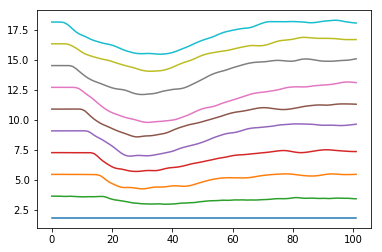

In [23]:
# GET NDARRAY WITH DATA
dumpDF = OutputReader('atomParameters.data','dump','id type x c_ptm[1] c_ptm[2] c_ptm[3] c_centro')    # need id as first dumplabel
simData = dumpDF.getNDArray()


# STEP 1, use c_ptmp[1] and c_entro to find interface
ptmData = simData[:,:,4].astype(float)
centroData = simData[:,:,7].astype(float)
xPositionData = simData[:,:,3].astype(float)






def averageXPositionOfInterfaceAtoms(ptmData,centroData,xPositionData,CentroLimit = 3, groupAtomsMaxError = .7):
    '''
    Input are matrices of atoms per row and data per timestep in columns
    Centero close to 0 is an atom on a Perfect FCC structure
    
    '''
    # CONDITION TO FIND FCC ATOMS: ptmData == 1 and centroData < CentroLimit
    matIndOfPTMFCC = ptmData == 1              # Boolean matrix that satisfies condition
    matIndOfCentroFCC = centroData < 2         # Boolean matrix arrays that satisfies condition
    FCCMatrix = np.multiply(matIndOfPTMFCC,matIndOfCentroFCC).astype(int)   # Boolean matrix that satisfies both conditions
    
    '''
    #CONDITIONS TO FIND LIQUID ATOM: ptmData == 0 and centroData > centroLimit
    matIndOfPTMLiq = ptmData == 0
    matIndOfCentroLiq = centroData > 2
    liqMatrix = np.multiply(matIndOfPTMLiq,matIndOfCentroLiq).astype(int)      #matrix with 1 for liq AND 0 FCC
    '''
    
    # Atoms from FCC ARRA THAT ARE solid then turn to liquid once
    goodAtomsIndices = getAtomIndicesThatWereSolidThenTurnedLiqOnce(FCCMatrix) # Indices of FCC atoms that melt and stay liquid due to interface
    goodAtomsFCCMatrix = FCCMatrix[goodAtomsIndices]                           # Matrice with only FCC atoms that melt  and stau liquid
    
    return AverageAtomsWithSimilarPositions(xPositionData[goodAtomsIndices],groupAtomsMaxError)    # Average atom x position values with similar starting x positions
    
    
        
        
        
        
def getAtomIndicesThatWereSolidThenTurnedLiqOnce(data):    #atoms that were FCC then all of a suddent turned to liquids
    atomIndCollection = []
    for ind in range(data.shape[0]):    # this could probably be turned to a boolean index array
        melted = 0            # turned to liquid
        addThisAtom = False
        onlyOnePhaseChange = True  # changed from FCC TO liq and no more changes
        atomStartedFCC = (data[ind][0]==1)
        for FCCValue in data[ind]:
            if atomStartedFCC and FCCValue == 0:
                melted = 1
            if melted and FCCValue == 1:
                onlyOnePhaseChange = False
            if atomStartedFCC and melted and onlyOnePhaseChange:
                addThisAtom = True
            else:
                addThisAtom = False 
        if addThisAtom:
            atomIndCollection.append(ind)         
    return atomIndCollection
       
    
# AVERAGE ATOMS THAT BEGIN AS SOLID THEN TURN TO LIQUID AROUND THE SAME STARTING POSITION
def AverageAtomsWithSimilarPositions(data,maxError = .7):
    meanData = []  # each element is collection of arrays with similar starting value and will be mean when returned
    meanValues = []
    for atomInd in range(data.shape[0]):
        if len(meanValues) == 0:
            meanData.append([data[atomInd]])
            meanValues.append(data[atomInd][0])
        else:
            added = False
            for meanValInd in range(len(meanValues)):
                if data[atomInd][0] > (meanValues[meanValInd] - maxError) and data[atomInd][0] < (meanValues[meanValInd] + maxError):
                    meanValues[meanValInd] = np.mean([meanValues[meanValInd],data[atomInd][0]])
                    meanData[meanValInd].append(data[atomInd])
                    added = True
            if not added:
                meanData.append([data[atomInd]])
                meanValues.append(data[atomInd][0])
    #return np.array(meanValues)
    return np.array([np.mean(np.array(group),axis=0) for group in meanData])
    
    
def getInterfaceVelocity(ptmData,centroData,xPositionData,CentroLimit = 3, groupAtomsMaxError = .7):
    groupedAtomMeansFCC = averageXPositionOfInterfaceAtoms(ptmData,centroData,xPositionData,CentroLimit = 3, groupAtomsMaxError = .7)
    
    # for visualizations
    for vect in groupedAtomMeansFCC:
        plt.plot(vect)
        
    return np.mean(np.gradient(np.array([xPos[0] for xPos in groupedAtomMeansFCC])))
   

print(getInterfaceVelocity(ptmData,centroData,xPositionData,CentroLimit = 3, groupAtomsMaxError = .7))


In [ ]:
one = pd.DataFrame(np.array([['a','a','a'],['b','b','b'],['c','c','c']]),columns=['let1','let2','let3'])
two = pd.DataFrame(np.array([['d','d','d'],['f','f','f'],['g','g','g']]),columns=['let1','let2','let3'])

df = pd.concat([one,two],keys=['1','2'])
print(df)

In [24]:
ar1 = np.array(['1x1','1y1','1z1','1w1'])
ar2 = np.array(['2x1','2y1','1z1','1w1'])
ar3 = np.array(['3x1','3y1','3z1','3w1'])


ar11 = np.array(['1x2','1y2','1z2','1w2'])
ar22 = np.array(['2x2','2y2','2z2','2w2'])
ar33 = np.array(['3x2','3y2','3z2','3w2'])

timesteps = 2
numAtoms = 3
fin1 = np.array([ar1,ar2,ar3])[:,None,:]

fin2 = np.array([ar11,ar22,ar33])[:,None,:]

print(np.append(fin1,fin2,axis=1))

[[['1x1' '1y1' '1z1' '1w1']
  ['1x2' '1y2' '1z2' '1w2']]

 [['2x1' '2y1' '1z1' '1w1']
  ['2x2' '2y2' '2z2' '2w2']]

 [['3x1' '3y1' '3z1' '3w1']
  ['3x2' '3y2' '3z2' '3w2']]]


In [25]:
# New Method

f = open('atomParameters.data','r')
datalines = [line.strip() for line in f.readlines()]

numAtoms = 648
widthOfHeader = 9
totData = []
numRows = int(len(datalines)/(numAtoms+widthOfHeader))
print(numRows)
lineBeforeAtomRepeat = numAtoms+widthOfHeader
for i in range(numAtoms):
    atomDataLineInd = widthOfHeader+i
    totData.append(np.array([datalines[atomDataLineInd+(ind*lineBeforeAtomRepeat)] for ind in range(numRows)]))
    
print(np.array(totData)[0])


102
['1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653'
 '1 1 0 0 inf 0 19.7653' '1 1 0 0 inf 0 19.7653

In [26]:
myArr = np.array([np.array([np.array(['1x1','1y1','1z1']),np.array(['1x2','1y2','1z2'])]),[['2x1','2y1','2z1'],['2x2','2y2','2z2']],[['3x1','3y1','3z1'],['3x2','3y2','3z2']]])
print(myArr)

#(numAtoms,numTimesteps,numParam)

[[['1x1' '1y1' '1z1']
  ['1x2' '1y2' '1z2']]

 [['2x1' '2y1' '2z1']
  ['2x2' '2y2' '2z2']]

 [['3x1' '3y1' '3z1']
  ['3x2' '3y2' '3z2']]]


In [27]:
print([data[9],data[9+1*lineBeforeAtomRepeat]])

IndexError: index 9 is out of bounds for axis 0 with size 0

In [28]:
print(np.array([2])+np.array([1]))

[3]


In [29]:
a = np.array([1])
print(a)
a[0] = np.mean([4,2])
print(a)

[1]
[3]
